# Avant propos
   Nous devons comprendre ce qui affecte si le cours des actions de GS(par exemple) va monter ou descendre.Par conséquent, nous devons incorporer autant d'informations (décrivant le stock sous différents aspects et angles) que possible. (Nous utiliserons les données quotidiennes 1.585 jours pour former les différents algorithmes (70% des données dont nous disposons) et prédire les 680 prochains jours (données de test). Ensuite, nous comparerons les résultats prévus avec des données de test (hold-out).
   ayant tant de fonctionnalités, nous devons effectuer quelques étapes importantes:
###### 1- Effectuer des contrôles statistiques de la «qualité» des données. Si les données que nous créons sont défectueuses, peu importe la sophistication de nos algorithmes, les résultats ne seront pas positifs. Les vérifications consistent à s'assurer que les données ne souffrent pas d'hétéroskédasticité, de multicolinéarité ou de corrélation série.
###### 2-Créer l'importance des fonctionnalités. Si une caractéristique (par exemple un autre stock ou un indicateur technique) n'a aucun pouvoir explicatif sur le stock que nous voulons prédire, il n'est pas nécessaire pour nous de l'utiliser dans la formation des réseaux neuronaux. Nous utiliserons XGBoost (eXtreme Gradient Boosting), un type d'algorithmes de régression d'arbre boosté.

   Comme dernière étape de notre préparation des données, nous créerons également des portefeuilles propres en utilisant l'analyse en composantes principales (ACP) afin de réduire la dimensionnalité des fonctionnalités créées à partir des encodeurs automatiques.




In [0]:
import matplotlib
from jedi.api.refactoring import inline

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings

import bert

from collections import deque

In [0]:
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)


In [0]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m/%d')

In [0]:
dataset_ex_df = pd.read_csv('https://raw.githubusercontent.com/adnaneaabbar/stock-trading-system/master/data/goldman_sachs.csv?token=AKSKTRTRHWQT7KCH6L2PACC62QAKE')


In [6]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))


There are 2265 number of days in the dataset.


In [7]:
dataset_ex_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,167.289993,170.130005,166.929993,168.839996,146.078110,6401800
1,2010-01-04,170.050003,174.250000,169.509995,173.080002,149.746597,9135000
2,2010-01-05,173.000000,176.259995,172.570007,176.139999,152.394012,11659400
3,2010-01-06,175.380005,175.380005,173.759995,174.259995,150.767426,7381100
4,2010-01-07,174.320007,178.750000,173.949997,177.669998,153.717728,8727400


###### Visualisons le stock des neuf dernières années. La ligne verticale en pointillés représente la séparation entre les données de formation et de test.


<Figure size 432x288 with 0 Axes>

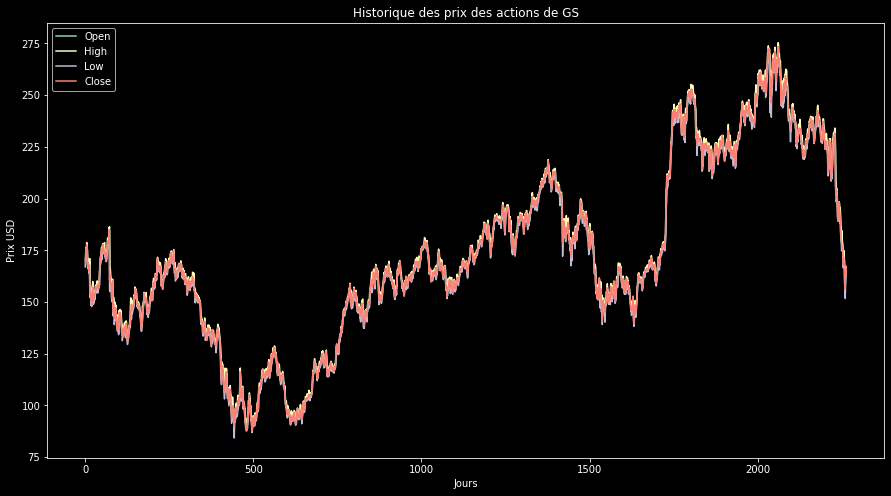

In [8]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use('dark_background')

plt.figure()
plt.figure(figsize=(15,8))
plt.plot(dataset_ex_df["Open"])
plt.plot(dataset_ex_df["High"])
plt.plot(dataset_ex_df["Low"])
plt.plot(dataset_ex_df["Close"])
plt.title('Historique des prix des actions de GS')
plt.ylabel('Prix USD')
plt.xlabel('Jours')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [14]:
num_training_days = int(dataset_ex_df.shape[0]*.75)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days,dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1698. Number of test days: 567.


In [0]:
import math

In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
#     dataset['26ema'] = pd.ewma(dataset['price'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span = 26).mean()
    #dataset['12ema'] = pd.ewma(dataset['price'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span = 12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    
    dataset['upper_band'] = dataset['ma21'] + 2*(dataset['Close'].rolling(20).std())
    dataset['lower_band'] = dataset['ma21'] - 2*(dataset['Close'].rolling(20).std())

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])

    return dataset

In [0]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])
dataset_TI_df = dataset_TI_df.drop(range(20))

##### Nous avons donc les indicateurs techniques (y compris MACD, bandes de Bollinger, etc.) pour chaque jour de bourse. Nous avons au total 12 indicateurs techniques.

In [18]:
dataset_TI_df.head(50)


,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,153.130005,152.374285,164.220476,160.321839,156.655072,-3.666767,9.607375,183.435226,145.005726,152.113609,152.130005,5.024735
21,156.940002,152.777143,163.653809,160.014868,156.700047,-3.314821,9.480630,182.615070,144.692549,155.331204,155.940002,5.049471
22,157.229996,153.098572,162.899047,159.766235,156.783365,-2.982871,9.053702,181.006450,144.791644,156.597065,156.229996,5.051329
23,150.679993,153.069999,161.686666,158.967168,155.827031,-3.140137,8.940246,179.567158,143.806174,152.652350,149.679993,5.008500
24,154.160004,153.449999,160.729523,158.550196,155.566566,-2.983631,8.151912,177.033348,144.425699,153.657453,153.160004,5.031483
25,151.100006,153.137144,159.464286,157.912052,154.870357,-3.041695,7.624973,174.714232,144.214340,151.952488,150.100006,5.011302
26,152.490005,153.675716,158.425238,157.452945,154.500079,-2.952866,7.110054,172.645346,144.205131,152.310833,151.490005,5.020520
27,153.630005,153.747144,157.571429,157.132636,154.364964,-2.767672,6.753288,171.078004,144.064854,153.190281,152.630005,5.028017
28,154.050003,153.334287,156.915715,156.876839,154.316124,-2.560714,6.156044,169.227803,144.603626,153.763429,153.050003,5.030765
29,153.929993,152.862858,156.194762,156.634468,154.256321,-2.378146,5.456336,167.107433,145.282090,153.874472,152.929993,5.029980


In [20]:
dataset_TI_df.isna().sum()

Close           0
ma7             0
ma21            0
26ema           0
12ema           0
MACD            0
20sd            0
upper_band      0
lower_band      0
ema             0
momentum        0
log_momentum    0
dtype: int64

In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

##### on va visualiser les 400 derniers jours de ces indicateurs.



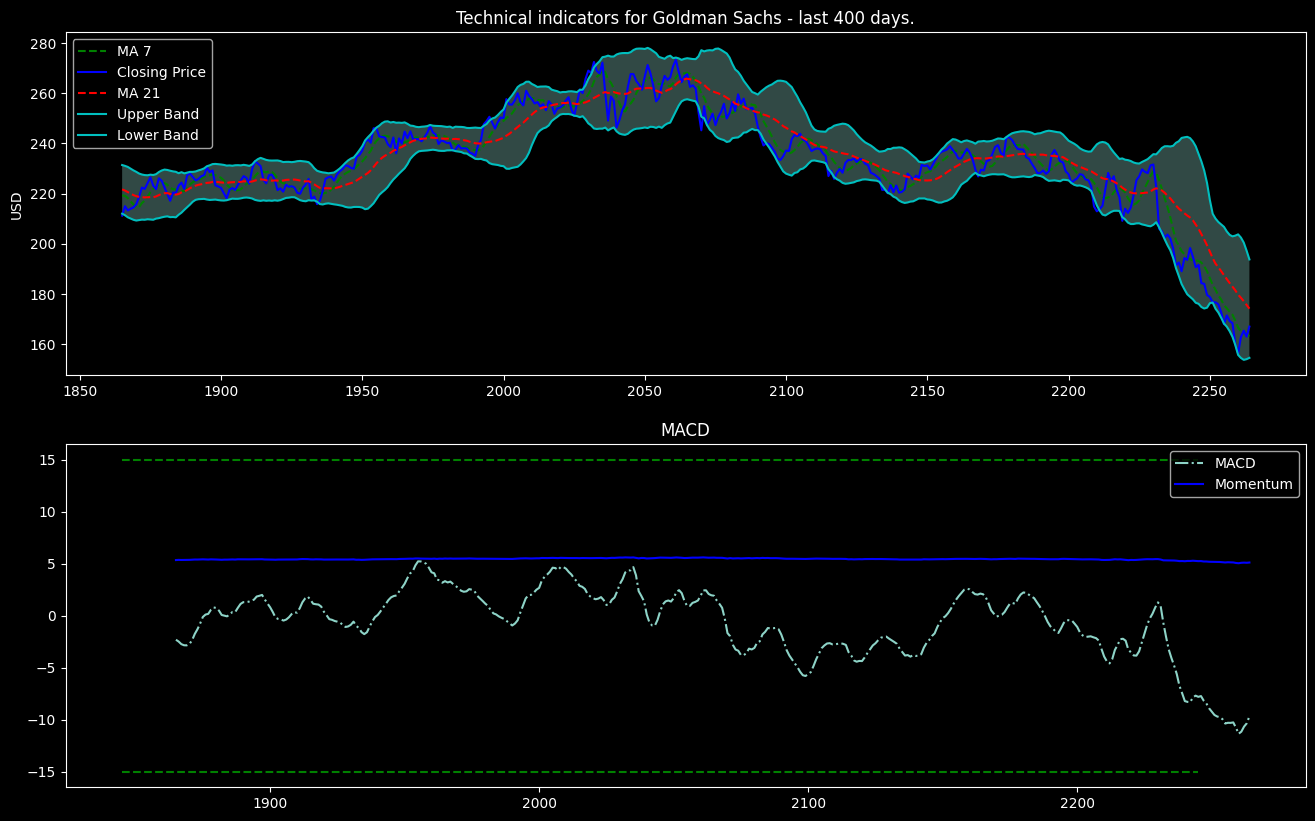

In [22]:
plot_technical_indicators(dataset_TI_df, 400)

# analyse fondamentale
Pour l'analyse fondamentale, nous effectuerons une analyse des sentiments sur toutes les nouvelles quotidiennes sur GS. En utilisant sigmoïde à la fin, le résultat sera compris entre 0 et 1. Plus le score est proche de 0 - plus les informations sont négatives (plus près de 1 indique un sentiment positif). Pour chaque jour, nous créerons le score quotidien moyen (sous forme de nombre compris entre 0 et 1) et l'ajouterons en tant que fonctionnalité.


In [0]:
data_FT = dataset_ex_df[['Date', 'Close']]


 Les transformées de Fourier prennent une fonction et créent une série d'ondes sinusoïdales (avec différentes amplitudes et trames). Lorsqu'elles sont combinées, ces ondes sinusoïdales se rapprochent de la fonction d'origine. Mathématiquement parlant, les transformations ressemblent à ceci:

$$ G (f) = \ int _ {- \ infty} ^ \ infty g (t) e ^ {- i 2 \ pi f t} dt $$

       Nous utiliserons les transformées de Fourier pour extraire les tendances globales et locales du stock GS, et aussi pour le débruiter un peu. Voyons donc comment cela fonctionne.

In [0]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

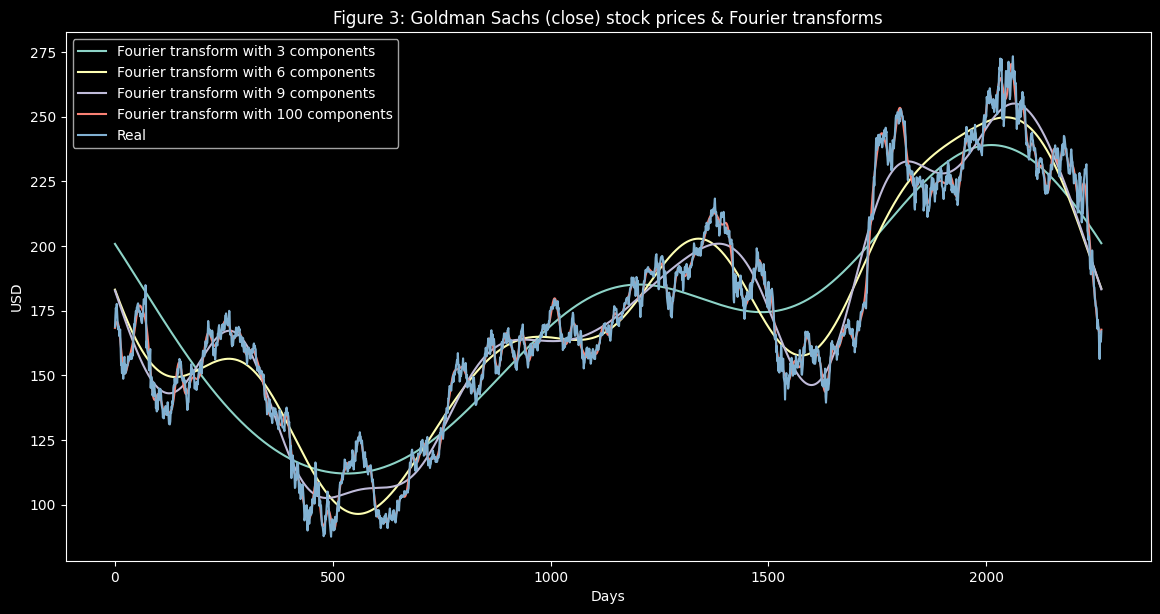

In [25]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

Comme vous le voyez sur la figure 3, plus nous utilisons de transformée de Fourier, plus la fonction d'approximation est proche du prix réel de l'action (la transformation de 100 composants est presque identique à la fonction d'origine - les lignes rouge et violette se chevauchent presque). 
Nous utilisons des transformées de Fourier dans le but d'extraire des tendances à long et à court terme, nous utiliserons donc les transformées à 3, 6 et 9 composants. Vous pouvez en déduire que la transformation à 3 composants sert de tendance à long terme.


Une autre technique utilisée pour débruiter les données est les ondelettes d'appel. Les ondelettes et la transformée de Fourier ont donné des résultats similaires, nous n'utiliserons donc que des transformées de Fourier.


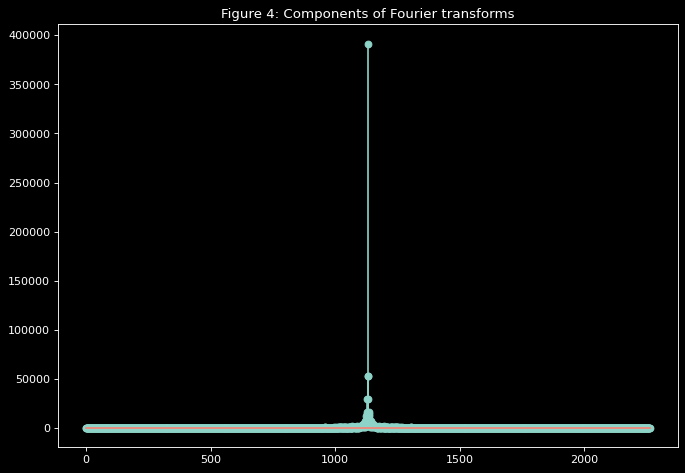

In [26]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

# ARIMA

ARIMA est une technique de prédiction des données de séries chronologiques. Nous allons montrer comment l'utiliser, et cependant ARIMA ne nous servira pas de prédiction finale, nous l'utiliserons comme technique pour débrouiller un peu le stock et pour (éventuellement) extraire de nouveaux motifs ou fonctionnalités.


In [27]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5465.888
Method:                       css-mle   S.D. of innovations              2.706
Date:                Sun, 24 May 2020   AIC                          10945.777
Time:                        19:14:53   BIC                          10985.851
Sample:                             1   HQIC                         10960.399
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.054     -0.020      0.984      -0.106       0.104
ar.L1.D.Close    -0.0205      0.021     -0.974      0.330      -0.062       0.021
ar.L2.D.Close     0.0140      0.021     

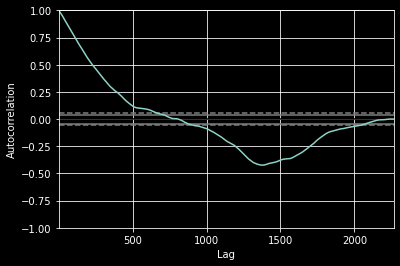

<Figure size 800x560 with 0 Axes>

In [28]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [29]:
from tqdm import tqdm
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

100%|██████████| 771/771 [02:34<00:00,  5.00it/s]


In [30]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 10.151


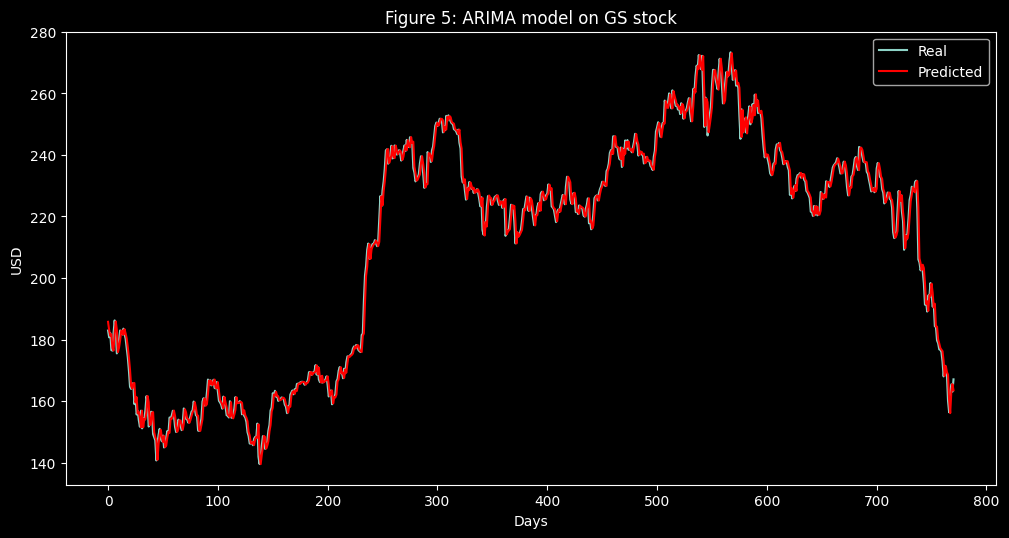

In [32]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()


Comme nous pouvons le voir sur la figure 5, ARIMA donne une très bonne approximation du cours réel des actions. Nous utiliserons le prix prévu via ARIMA en tant que fonctionnalité d'entrée dans le LSTM car, comme nous l'avons mentionné précédemment, nous voulons capturer autant de fonctionnalités et de modèles concernant Goldman Sachs que possible. Nous allons tester MSE (erreur quadratique moyenne) de 10.151, ce qui en soi n'est pas un mauvais résultat (étant donné que nous avons beaucoup de données de test), mais nous ne l'utiliserons que comme fonctionnalité dans le LSTM.


# Contrôles statistiques


Il est très important de s'assurer que les données sont de bonne qualité pour nos modèles. Afin de nous assurer que nos données sont appropriées, nous effectuerons quelques vérifications simples afin de nous assurer que les résultats que nous obtenons et observons sont bien réels, plutôt que compromis, car la distribution des données sous-jacentes souffre d'erreurs fondamentales.


## Hétéroscédasticité, multicollinéarité, corrélation série


L'hétéroscédasticité conditionnelle se produit lorsque les termes d'erreur (la différence entre une valeur prédite par une régression et la valeur réelle) dépendent des données - par exemple, les termes d'erreur augmentent lorsque le point de données (le long de l'axe des x) augmente.

La multicollinéarité est lorsque les termes d'erreur (également appelés résidus) dépendent les uns des autres.

La corrélation série se produit lorsqu'une donnée (entité) est une formule (ou dépend entièrement) d'une autre entité.



# Ingénierie des fonctionnalités


In [33]:
dataset_total_df= dataset_TI_df

print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has 2245 samples, and 12 features.


### Importance des fonctionnalités avec XGBoost



Avec autant de fonctionnalités, nous devons nous demander si toutes sont vraiment indicatives de la direction que prendra le stock GS. Par exemple, nous avons inclus les taux LIBOR libellés en USD dans l'ensemble de données parce que nous pensons que des changements dans le LIBOR pourraient indiquer des changements dans l'économie, ce qui, à son tour, pourrait indiquer des changements dans le comportement des stocks du GS. Mais nous devons tester. Il existe de nombreuses façons de tester l'importance des fonctionnalités, mais celle que nous appliquerons utilise XGBoost, car elle donne l'un des meilleurs résultats en termes de problèmes de classification et de régression.

Étant donné que l'ensemble de données d'entités est assez volumineux, aux fins de présentation ici, nous n'utiliserons que les indicateurs techniques. Pendant le test d'importance des fonctionnalités réelles, toutes les fonctionnalités sélectionnées se sont révélées quelque peu importantes, nous n'exclurons donc rien lors de la formation du GAN.


In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [0]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [0]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)


In [37]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[19:23:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
eval_result = regressor.evals_result()


In [0]:
training_rounds = range(len(eval_result['validation_0']['rmse']))



Traçons les erreurs de training et de validation afin d'observer la formation et de vérifier le sur-ajustement (il n'y a pas de sur-ajustement)


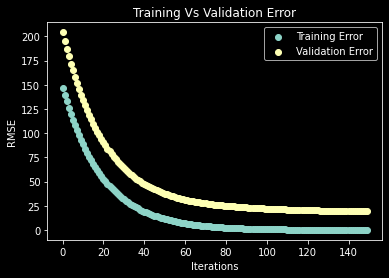

In [40]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()